In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from transformers import GPT2TokenizerFast, GPT2Model
from transformers import AdamW
from utils.datasets import TextDataset
from utils.lr_finder import run_lr_finder
from models.gpt2 import GPT2ForClassification

In [2]:
MODEL = "pierreguillou/gpt2-small-portuguese"

# Loading tweet dataset

In [3]:
train_df = pd.read_csv("/home/kenzo/datasets/cleaned_tweetsentbr/train.tsv", sep="\t", names=["id", "label", "alfa", "text"], index_col=0)
test_df = pd.read_csv("/home/kenzo/datasets/cleaned_tweetsentbr/test.tsv", sep="\t", names=["id", "label", "alfa", "text"], index_col=0)

In [4]:
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL)

In [5]:
train_ds = TextDataset.from_df(train_df, tokenizer, max_seq_len=64)
test_ds = TextDataset.from_df(test_df, tokenizer, max_seq_len=64)

# Preparing model

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from functools import partial

metrics = {
    "accuracy": accuracy_score,
    "precision": partial(precision_score, average="macro"),
    "recall": partial(recall_score, average="macro"),
    "f1": partial(f1_score, average="macro"),
}

In [7]:
gpu = torch.device("cuda:2")

In [8]:
gpt_model = GPT2Model.from_pretrained(MODEL)

In [9]:
model = GPT2ForClassification(gpt_model, 64, 3, metrics, device=gpu).cuda(gpu)

In [10]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

# Finding a good learning rate

In [11]:
batches = len(train_dl)
epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-7) 
# scheduler = OneCycleLR(optimizer, max_lr=5e-5, steps_per_epoch=batches, epochs=epochs)
criterion = nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.06E-04


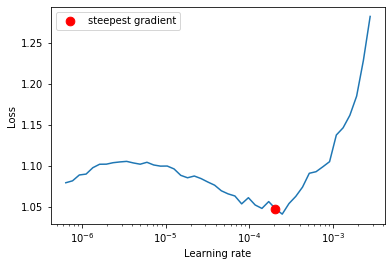

In [12]:
run_lr_finder(train_dl, model, optimizer, criterion, device=gpu)

In [13]:
scheduler = OneCycleLR(optimizer, max_lr=2e-4, steps_per_epoch=batches, epochs=epochs)

# Model training

In [14]:
train, test = model.fit(epochs, train_dl, test_dl, criterion, optimizer, scheduler=scheduler)


Epoch: 1
	train_loss: 0.9355406424441894 // test_loss: 0.80071039383228// metrics: {'accuracy': 0.6401299756295694, 'precision': 0.6100398404191631, 'recall': 0.5976132694733606, 'f1': 0.5942029767040552}




Epoch: 2
	train_loss: 0.69360072581799 // test_loss: 0.8079634048999884// metrics: {'accuracy': 0.6669374492282697, 'precision': 0.6519418438322816, 'recall': 0.6189368657843034, 'f1': 0.6211251261728248}




Epoch: 3
	train_loss: 0.3731517846901695 // test_loss: 0.841481042213929// metrics: {'accuracy': 0.6770917952883835, 'precision': 0.6568324498231232, 'recall': 0.6573445570484756, 'f1': 0.6569506063484636}




In [15]:
# torch.save(model.bert.state_dict(), "data/checkpoints/bert_tweetsent_br.ckpt")